In [1]:
import pandas as pd
import numpy as np
import itertools
import re
import os
import nltk

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS

#!pip install sklearn --upgrade
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.utils._testing import ignore_warnings 
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning 
from sklearn import tree

from joblib import dump, load


In [2]:
# Dataset

train = pd.read_excel('data/Constraint_English_Train.xlsx')
val = pd.read_excel('data/Constraint_English_Val.xlsx')


# Data cleaning

In [3]:
# Function to clean data

stops = set().union(stopwords.words("english"), STOPWORDS)

def cleantext(string):
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)  
    tx = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [4]:
# Cleaning dataset

train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
train

,id,tweet,label
0,1,cdc currently reports 99031 deaths general dis...,real
1,2,states reported 1121 deaths small rise last tu...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,indiafightscorona 1524 covid testing laborator...,real
4,5,populous states generate large case counts loo...,real
...,...,...,...
6415,6416,tiger tested positive covid 19 please stay awa...,fake
6416,6417,autopsies prove covid 19 blood clot pneumonia ...,fake
6417,6418,post claims covid 19 vaccine already developed...,fake
6418,6419,aamir khan donate 250 cr pm relief cares fund,fake


In [5]:
classes = {"real":1,"fake":0}
train["label"].replace(classes, inplace=True)
val["label"].replace(classes, inplace=True)

# Classification

In [6]:
# Function to display the confusion matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title = 'Confusion matrix',
                          cmap = None,
                          normalize = True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize = (5, 4))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color = "white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# Function to print the classification results

def print_metrices(pred, true):
    #print(confusion_matrix(true,pred))
    #print(classification_report(true,pred,))
    print("Accuracy : ", accuracy_score(pred, true))
    print("Precison : ", precision_score(pred, true))
    print("Recall : ", recall_score(pred, true))
    print("F1 : ", f1_score(pred, true))

In [8]:
cores = os.cpu_count()-1

In [9]:
results={}

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   19.8s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:   34.2s
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:   53.0s
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1600 out of 1600 | elapsed:  1.7min finished


Best params:  {'c__C': 1, 'c__dual': False, 'c__loss': 'squared_hinge', 'c__penalty': 'l2', 'tfidf__norm': 'l2', 'tfidf__smooth_idf': False, 'tfidf__use_idf': True}
Accuracy :  0.9373831775700935
Precison :  0.9303571428571429
Recall :  0.9489981785063752
F1 :  0.939585211902615


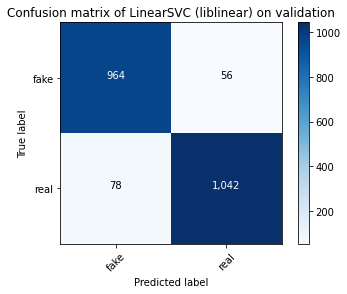

In [10]:
# Linear Support Vector Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('c', LinearSVC())])
param_grid = {'c__C':[0.01,0.1,1,10,100],'c__penalty':['l1','l2'],'c__dual':[False, True],
              'c__loss':['hinge','squared_hinge']
              ,'tfidf__norm':['l1','l2'],'tfidf__use_idf':[True,False],'tfidf__smooth_idf':[True,False]}
              #,'tfidf__sublinear_tf':[True,False]}

with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
    CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1', 
                      n_jobs=cores, error_score=0.0, verbose=2)
    CV.fit(train['tweet'],train['label'])      
    print('Best params: ', CV.best_params_)    
    pred = CV.predict(val['tweet'])
    
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of LinearSVC (liblinear) on validation')

results['LinearSVC']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   44.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  9.2min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 16.5min
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed: 18.7min finished


Best params:  {'svc__C': 10, 'svc__coef0': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}
Accuracy :  0.938785046728972
Precison :  0.9339285714285714
Recall :  0.9483227561196736
F1 :  0.9410706252811516


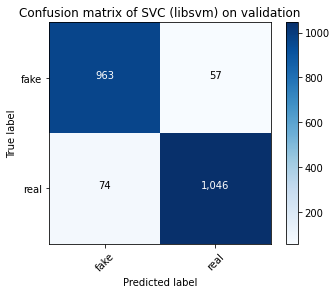

In [11]:
# C-Support Vector Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('svc', SVC())])
param_grid = {'svc__C':[0.1,1,10],'svc__kernel':['linear','poly','rbf','sigmoid']
              ,'svc__degree':[1,2,3],'svc__gamma':['scale','auto'],'svc__coef0':[0.0,1.0]}
              #,'svc__tol': [1e-2,1e-3,1e-4]
              #,'svc__shrinking':[True,False]

with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
    CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1', 
                      n_jobs=cores, error_score=0.0, verbose=2)
    CV.fit(train['tweet'],train['label'])      
    print('Best params: ', CV.best_params_)    
    pred = CV.predict(val['tweet'])
    
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of SVC (libsvm) on validation')

results['SVC']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   11.8s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   28.2s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:   57.2s
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed:  2.9min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 2880 out of 2880 | elapsed:  4.2min finished
C:\Users\ema\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best params:  {'lr__C': 0.1, 'lr__max_iter': 1000, 'lr__penalty': 'none', 'lr__solver': 'sag', 'lr__tol': 0.01}
Accuracy :  0.9336448598130841
Precison :  0.9276785714285715
Recall :  0.9445454545454546
F1 :  0.936036036036036


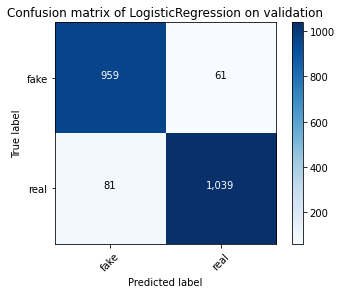

In [12]:
# Logistic Regression Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('lr', LogisticRegression())])
param_grid = {'lr__penalty':['none','l1','l2','elasticnet'], 'lr__tol':[1e-4,1e-3,1e-2],
              'lr__C':[0.1,1.0,10,100], 'lr__solver':['newton-cg','lbfgs','liblinear','sag'],
              'lr__max_iter':[10,100,1000]
             }

#with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1',
                          n_jobs=cores, error_score=0.0, verbose=2)
CV.fit(train['tweet'],train['label'])      
print('Best params: ', CV.best_params_)    
pred = CV.predict(val['tweet'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of LogisticRegression on validation')

results['LogisticRegression']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   19.8s
[Parallel(n_jobs=5)]: Done 160 out of 160 | elapsed:   35.0s finished


Best params:  {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Accuracy :  0.9126168224299065
Precison :  0.9142857142857143
Recall :  0.9183856502242153
F1 :  0.916331096196868


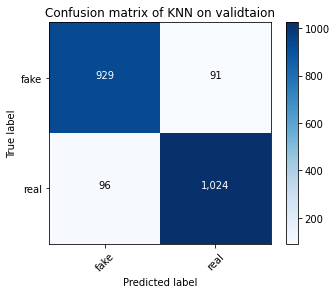

In [13]:
# k-nearest neighbors Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors':[1,3,5,7],'knn__weights':['uniform','distance']
              ,'knn__algorithm':['auto'],'knn__metric':['manhattan','euclidean','mahalanobis','jaccard']}

with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
    CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1', 
                      n_jobs=cores, error_score=0.0, verbose=2)
    CV.fit(train['tweet'],train['label'])      
    print('Best params: ', CV.best_params_)    
    pred = CV.predict(val['tweet'])
    
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of KNN on validtaion')

results['KNeighbors']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   14.2s
[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed:   27.2s finished


Best params:  {'dt__criterion': 'entropy', 'dt__max_depth': 200, 'dt__max_features': 'auto', 'dt__splitter': 'best'}
Accuracy :  0.8177570093457944
Precison :  0.8375
Recall :  0.8184991273996509
F1 :  0.8278905560458959


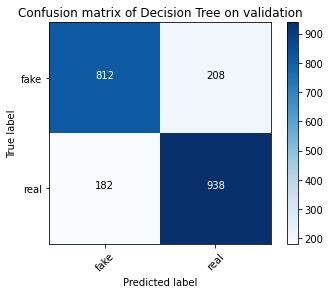

In [14]:
# Decision Tree Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('dt', tree.DecisionTreeClassifier())])
param_grid = {'dt__criterion':['gini','entropy'],'dt__splitter':['best','random']
              ,'dt__max_features':['auto','sqrt','log2']
              ,'dt__max_depth':[100,200,300,400,500]}

with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
    CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1', 
                      n_jobs=cores, error_score=0.0, verbose=2)
    CV.fit(train['tweet'],train['label'])      
    print('Best params: ', CV.best_params_)    
    pred = CV.predict(val['tweet'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of Decision Tree on validation')

results['DecisionTree']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   30.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  7.8min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed: 22.4min
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed: 24.3min finished


Best params:  {'rf__bootstrap': False, 'rf__criterion': 'gini', 'rf__max_features': 'log2', 'rf__max_samples': 0.75, 'rf__n_estimators': 200, 'rf__oob_score': False}
Accuracy :  0.9327102803738317
Precison :  0.9125
Recall :  0.9569288389513109
F1 :  0.9341864716636198


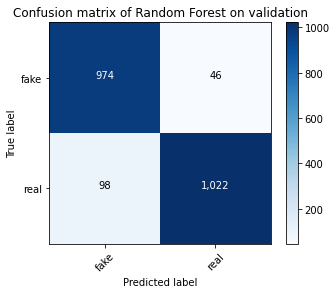

In [15]:
# Random Forest Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('rf', RandomForestClassifier())])
param_grid = {'rf__n_estimators':[100,150,200],'rf__criterion':['gini','entropy']
              ,'rf__max_features':['auto','sqrt','log2'],'rf__bootstrap':[True,False],'rf__oob_score':[True,False]
              ,'rf__max_samples':[0.25,0.50,0.75]}

with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
    CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1', 
                      n_jobs=cores, error_score=0.0, verbose=2)
    CV.fit(train['tweet'],train['label'])      
    print('Best params: ', CV.best_params_)    
    pred = CV.predict(val['tweet'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of Random Forest on validation')

results['RandomForest']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   13.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:   15.3s finished


Best params:  {'pa__C': 0.1, 'pa__max_iter': 1000, 'pa__tol': 0.01}
Accuracy :  0.9364485981308411
Precison :  0.9375
Recall :  0.9408602150537635
F1 :  0.9391771019677997


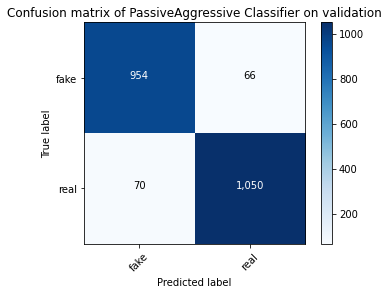

In [16]:
# PassiveAggressive Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('pa', PassiveAggressiveClassifier())])
param_grid = {'pa__C':[0.1,0.5,1,10], 'pa__max_iter': [100,1000,10000], 'pa__tol':[1e-4,1e-3,1e-2] }

with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
    CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1', 
                      n_jobs=cores, error_score=0.0, verbose=2)
    CV.fit(train['tweet'],train['label'])      
    print('Best params: ', CV.best_params_)    
    pred = CV.predict(val['tweet'])
    
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of PassiveAggressive Classifier on validation')

results['PassAggressive']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   11.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 31.0min
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed: 34.8min finished


Best params:  {'ab__algorithm': 'SAMME', 'ab__base_estimator': LinearSVC(), 'ab__learning_rate': 1, 'ab__n_estimators': 25}
Accuracy :  0.9112149532710281
Precison :  0.9276785714285715
Recall :  0.9050522648083623
F1 :  0.9162257495590829


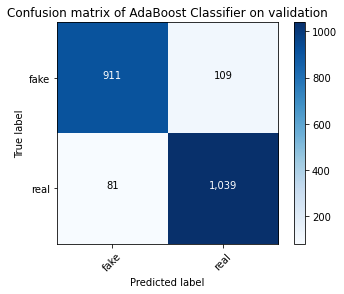

In [17]:
# AdaBoost Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('ab', AdaBoostClassifier())])
param_grid = {'ab__base_estimator':[tree.DecisionTreeClassifier(),LinearSVC(),SVC()],'ab__n_estimators':[10,25,50]
              ,'ab__learning_rate':[0.1,1,10,100],'ab__algorithm':['SAMME','SAMME.R']}

with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
    CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1', 
                      n_jobs=cores, error_score=0.0, verbose=2)
    CV.fit(train['tweet'],train['label'])      
    print('Best params: ', CV.best_params_)    
    pred = CV.predict(val['tweet'])
    
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of AdaBoost Classifier on validation')

results['AdaBoost']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   36.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:  5.3min finished


Best params:  {'gbc__criterion': 'mse', 'gbc__learning_rate': 1, 'gbc__loss': 'exponential', 'gbc__max_depth': 7, 'gbc__max_features': 'sqrt', 'gbc__n_estimators': 100}
Accuracy :  0.8967289719626168
Precison :  0.8875
Recall :  0.9127640036730946
F1 :  0.8999547306473518


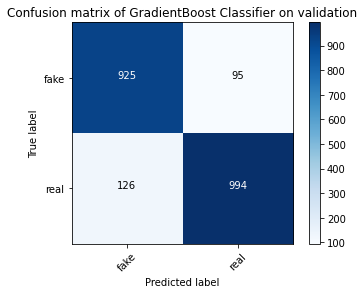

In [18]:
# GradientBoosting Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('gbc', GradientBoostingClassifier())])
param_grid = {'gbc__loss':['deviance','exponential'],'gbc__learning_rate':[0.1,1],'gbc__n_estimators':[100]
              ,'gbc__criterion':['friedman_mse','mse']
              ,'gbc__max_depth':[3,5,7],'gbc__max_features':['auto','sqrt','log2']}
              #,'gbc__tol':[1e-3,1e-4,1e-5]
              #,'gbc__subsample':[0.5,0.7,1.0],'gbc__validation_fraction':[0.1,0.2,0.3]
              #,'gbc__n_iter_no_change':[3,5,10]

with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
    CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1', 
                      n_jobs=cores, error_score=0.0, verbose=2)
    CV.fit(train['tweet'],train['label'])      
    print('Best params: ', CV.best_params_)    
    pred = CV.predict(val['tweet'])
    
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of GradientBoost Classifier on validation')

results['GradientBoosting']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    4.3s finished


Best params:  {'mnb__alpha': 0.1, 'mnb__fit_prior': False}
Accuracy :  0.9196261682242991
Precison :  0.9258928571428572
Recall :  0.9209591474245116
F1 :  0.9234194122885129


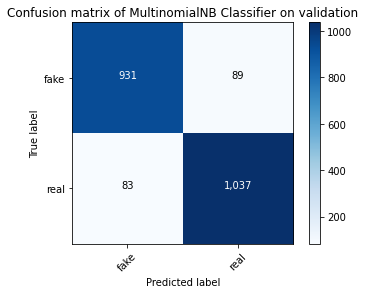

In [19]:
# MultinomialNB Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('mnb', MultinomialNB())])
param_grid = {'mnb__fit_prior':[True,False],'mnb__alpha':[0.01,0.1,1.0,10,100]}

with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
    CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1', 
                      n_jobs=cores, error_score=0.0, verbose=2)
    CV.fit(train['tweet'],train['label'])      
    print('Best params: ', CV.best_params_)    
    pred = CV.predict(val['tweet'])
    
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of MultinomialNB Classifier on validation')

results['MultinomialNB']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   12.2s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:   15.2s finished


Best params:  {'bnb__alpha': 0.01, 'bnb__binarize': 0.0, 'bnb__fit_prior': True}
Accuracy :  0.9219626168224299
Precison :  0.89375
Recall :  0.9542421353670162
F1 :  0.9230059935454126


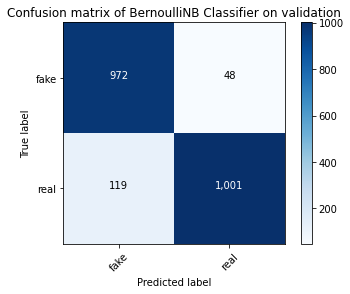

In [20]:
# BernoulliNB Classifier

pipeline = Pipeline([('bow', CountVectorizer()),  ('tfidf', TfidfTransformer()),  ('bnb', BernoulliNB())])
param_grid = {'bnb__fit_prior':[True,False],'bnb__alpha':[0.01,0.1,1.0,10,100], 'bnb__binarize':[0.0,0.3,0.6,1.0]}

with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]):
    CV = GridSearchCV(pipeline, param_grid, scoring = ['f1','accuracy','precision'], refit='f1', 
                      n_jobs=cores, error_score=0.0, verbose=2)
    CV.fit(train['tweet'],train['label'])      
    print('Best params: ', CV.best_params_)    
    pred = CV.predict(val['tweet'])
    
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of BernoulliNB Classifier on validation')

results['BernoulliNB']=[accuracy_score(pred,val['label']), precision_score(pred,val['label']), recall_score(pred,val['label']), f1_score(pred,val['label'])]


## Comparison of results produced by the classifiers

In [21]:
# Results in DF

index = ['accuracy' , 'precision', 'recall' , 'f1']
resultsDF = pd.DataFrame(results, index=index)

accuracy = resultsDF.values[0].tolist()
precision = resultsDF.values[1].tolist()
recall = resultsDF.values[2].tolist()
f1 = resultsDF.values[3].tolist()

#ax = resultsDF.plot.bar(rot=0, subplots=True)

In [22]:
# Function to round the result values

def rounded_value(result): 
    return list(map(lambda a: round(a, 3), result))


In [23]:
# Function to display the results in plots

def plot_results(data, labels, bounds, yAxis, color):

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize = (16,5))
    rects1 = ax.bar(x, data, width, color=color)

    ax.set_ylabel(yAxis, labelpad = 12, fontsize = 22)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize = 11)

    ax.bar_label(rects1, padding = 1, fontsize = 18)

    fig.tight_layout()

    plt.ylim(bounds)

    plt.show()
    

,accuracy,precision,recall,f1
LinearSVC,0.937383,0.930357,0.948998,0.939585
SVC,0.938785,0.933929,0.948323,0.941071
LogisticRegression,0.933645,0.927679,0.944545,0.936036
KNeighbors,0.912617,0.914286,0.918386,0.916331
DecisionTree,0.817757,0.837500,0.818499,0.827891
RandomForest,0.932710,0.912500,0.956929,0.934186
PassAggressive,0.936449,0.937500,0.940860,0.939177
AdaBoost,0.911215,0.927679,0.905052,0.916226
GradientBoosting,0.896729,0.887500,0.912764,0.899955
MultinomialNB,0.919626,0.925893,0.920959,0.923419



Max Accuracy:  0.939 in SVC
Max Precision:  0.938 in PassAggressive
Max Recall:  0.957 in RandomForest
Max F1:  0.941 in SVC



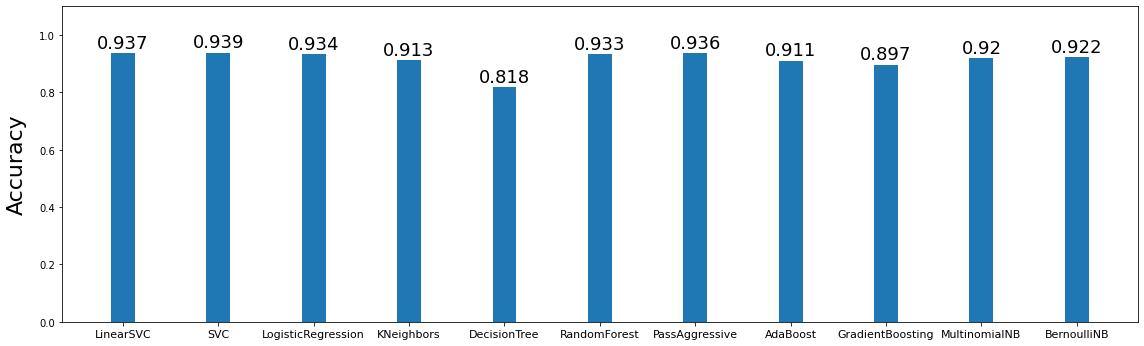

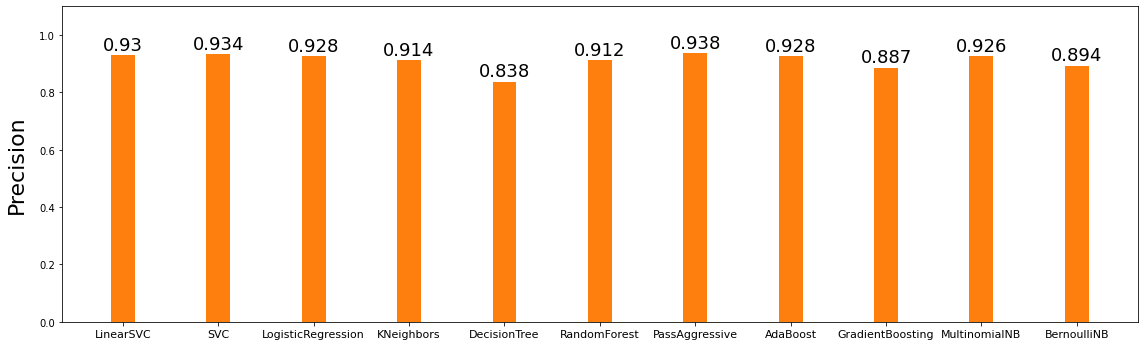

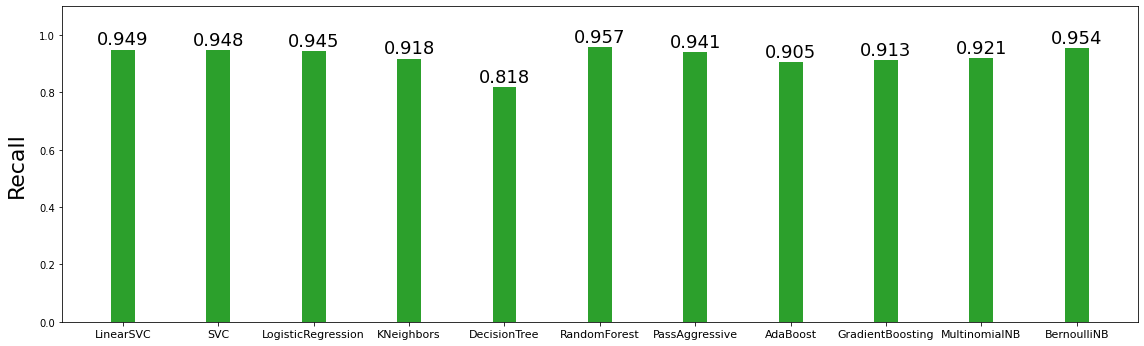

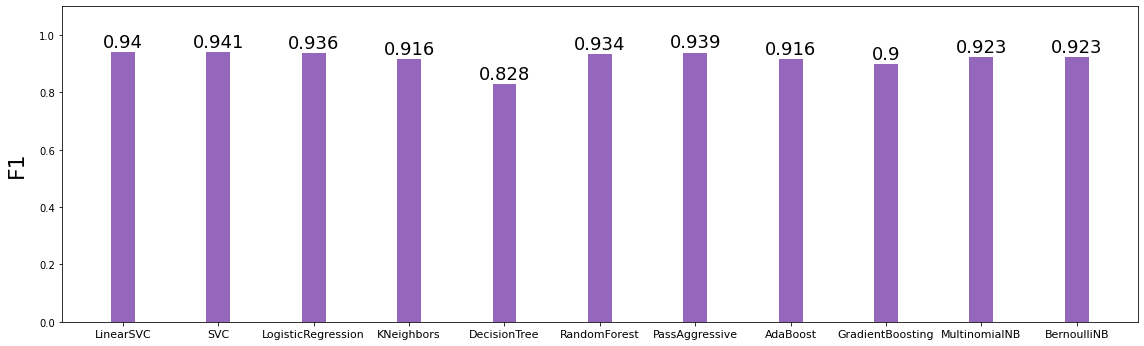

In [24]:
# Results visualizzation

accuracy = rounded_value(accuracy)
precision = rounded_value(precision)
recall = rounded_value(recall)
f1 = rounded_value(f1)

bounds = [0,1.1]

labels = resultsDF.columns

display(resultsDF.T)

maxValuesObj = resultsDF.idxmax(axis=1)

print('\n\033[1m' + 'Max Accuracy: ' + '\033[0m', max(accuracy), 'in ' + maxValuesObj[0])
print('\033[1m' + 'Max Precision: ' + '\033[0m', max(precision), 'in ' + maxValuesObj[1])
print('\033[1m' + 'Max Recall: ' + '\033[0m', max(recall), 'in ' + maxValuesObj[2])
print('\033[1m' + 'Max F1: ' + '\033[0m', max(f1), 'in ' + maxValuesObj[3] + '\n')

plot_results( accuracy, labels, bounds, 'Accuracy', 'tab:blue')
plot_results( precision,labels, bounds, 'Precision', 'tab:orange')
plot_results( recall, labels, bounds, 'Recall', 'tab:green')
plot_results( f1, labels, bounds, 'F1', 'tab:purple')
